# Question 1:  Pose Graph Optimization for 1D SLAM

A solved example for 1D SLAM which optimizes for pose variables using weighted least squares method (Gauss Newton) has been explained in the class. You can view it at `examples/1D-SLAM.ipynb`. Your first task is to code this from scratch.

For this section, you have to calculate Jacobian analytically yourself and use it. However, you can check how correct it is using `jax`'s `jacobian`. Its usage is explained in the supplementary notebook (`examples/`).

## How to get started?

1. Go through the example and understand the optimization procedure.
2. Generate the data as in the example.
3. Write the derivatives of the function with respect to the constraints
4. Create the final jacobian and write the update steps using Gauss Newton

This tiny example will help make sense of the next question, as it's largely just an extension of this.

Finally, plot the loop closure constraint, poses, and error at every iteration as well. Since this is a one dimensional example, you can just assume x = y.

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import jacfwd

In [2]:
class SLAM_1D:
    def __init__(self, motion_model, num_oc, num_lcc, max_iter=10, lr=1e-2, h=0.001):

        self.motion_model = motion_model

        self.num_oc = num_oc
        self.num_lcc = num_lcc

        self.max_iter = max_iter

        self.lr = lr
        self.h = h

    def get_poses(self, control_inputs):

        n = len(control_inputs)
        poses = [0] * n

        for i in range(1, self.num_oc + 1):
            poses[i] = poses[i - 1] + control_inputs[i - 1]
        return np.array(poses)

    def get_residual(self, pose, contol_inputs):
        x = pose[:]
        u = contol_inputs[:]

        f_x = []
        for i in range(self.num_oc):
            res = self.motion_model(x[i], u[i]) - x[i + 1]
            f_x.append(res)
        f_x.append(self.motion_model(x[0], u[-1]) - x[-1])
        f_x.append(x[0] - 0)

        return np.array(f_x)

    def get_information_matrix(self, sigma=1e-2, lambda_=1e-2, pi=1e-3):
        diag = [sigma] * self.num_oc + [lambda_] * self.num_lcc + [pi]
        return np.linalg.inv(np.diag(diag))

    def get_jacobian(self, pose, contol_inputs):
        f_x = self.get_residual(pose, contol_inputs)

        jacobian = []
        for i, param in enumerate(pose):
            pose_ = pose.copy()
            pose_[i] += self.h
            f_x_h = self.get_residual(pose_, contol_inputs)
            partial_derv = (f_x_h - f_x) / self.h
            jacobian.append(partial_derv)
        jacobian = np.array(jacobian).T

        return jacobian

    def gauss_newton(self, control_inputs):
        poses = self.get_poses(control_inputs)
        residuals = []
        loop_constraints = []
        
        x_range = list(range(self.max_iter))
        
        plt.plot(poses)
        plt.plot(x_range, [0]*self.max_iter)
        plt.title('Initial Pose')
        plt.show()
        
        for idx in range(self.max_iter):

            f_x = self.get_residual(poses, control_inputs)
            residuals.append(np.linalg.norm(f_x))
            loop_constraints.append(f_x[-2])

            sigma = self.get_information_matrix()

            J = self.get_jacobian(poses, control_inputs)
            H = J.T @ sigma @ J

            delta = np.linalg.pinv(H) @ J.T @ sigma.T @ f_x

            poses = poses - self.lr * delta
            
            plt.plot(poses)
            plt.plot(x_range, [0]*self.max_iter)
            plt.title(f'Pose after Iteration {idx}')
            plt.show()
        
        plt.plot(x_range, residuals, label='error')
        plt.plot(x_range, loop_constraints, label='loop_constr')
        plt.title('Error & Loop Constraints')
        plt.legend()
        plt.show()
        
        return np.round(poses, 2)

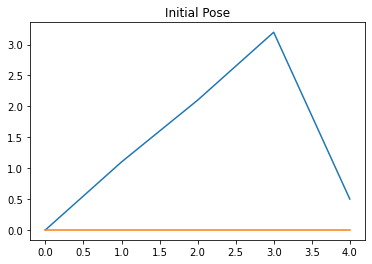

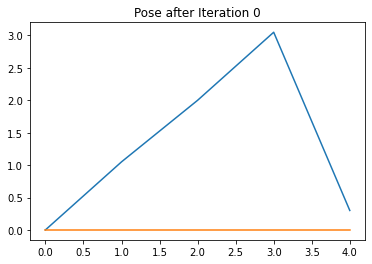

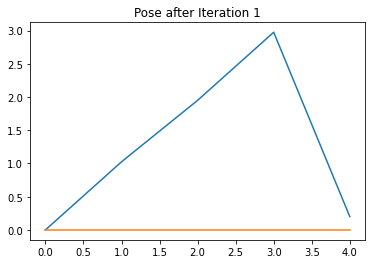

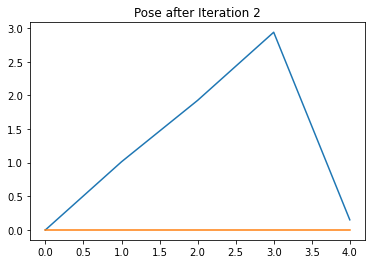

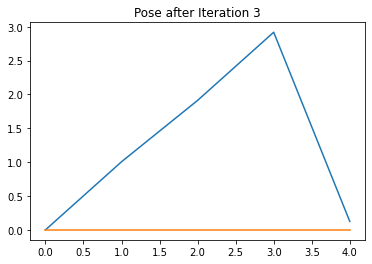

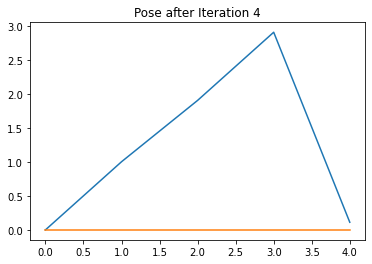

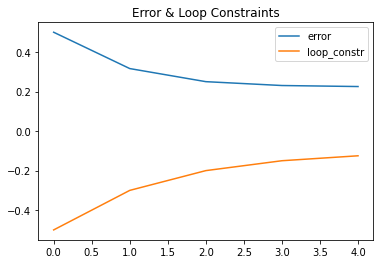

Initial Residual
 [ 0.   0.   0.   0.  -0.5  0. ]
Final Residual
 [ 0.1   0.09  0.1   0.1  -0.11  0.  ]
Initial Pose
 [0.  1.1 2.1 3.2 0.5]
Final Pose
 [0.   1.   1.91 2.91 0.11]


In [3]:
motion_model = lambda x, y: x + y

num_oc = 4
num_lcc = 1

control_inputs = np.array([1.1, 1.0, 1.1, -2.7, 0.0])

slam_1d = SLAM_1D(motion_model, num_oc=num_oc, num_lcc=num_lcc, lr=5e-1, max_iter=5)

inital_pose = slam_1d.get_poses(control_inputs)
initial_residual = slam_1d.get_residual(inital_pose, control_inputs)

final_pose = slam_1d.gauss_newton(control_inputs)
final_residual = slam_1d.get_residual(final_pose, control_inputs)

print("Initial Residual\n", initial_residual)
print("Final Residual\n", final_residual)

print("Initial Pose\n", inital_pose)
print("Final Pose\n", final_pose)

In [4]:
## Jacobian verification

def get_residual(pose, contol_inputs):
    x = jnp.asarray(pose[:])
    u = jnp.asarray(contol_inputs[:])

    f_x = []
    for i in range(num_oc):
        res = motion_model(x[i], u[i]) - x[i + 1]
        f_x.append(res)
    f_x.append(motion_model(x[0], u[-1]) - x[-1])
    f_x.append(x[0] - 0)

    return jnp.asarray(f_x)

poses = slam_1d.get_poses(control_inputs)
print("Initial Pose\n", poses)

residual = lambda x: get_residual(x, control_inputs)

J = jacfwd(residual)
jax_jacobian = J(poses)
print("JAX Jacobian\n", jax_jacobian)

numpy_jacobian = slam_1d.get_jacobian(poses, control_inputs)
print("Numpy Jacobian\n", numpy_jacobian)

Initial Pose
 [0.  1.1 2.1 3.2 0.5]
JAX Jacobian
 [[ 1. -1.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.]
 [ 0.  0.  1. -1.  0.]
 [ 0.  0.  0.  1. -1.]
 [ 1.  0.  0.  0. -1.]
 [ 1.  0.  0.  0.  0.]]
Numpy Jacobian
 [[ 1. -1.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.]
 [ 0.  0.  1. -1.  0.]
 [ 0.  0.  0.  1. -1.]
 [ 1.  0.  0.  0. -1.]
 [ 1.  0.  0.  0.  0.]]


In [5]:
def frobNorm(P1, P2, str1="mat1", str2="mat2"):
    jnp.set_printoptions(suppress=True)
    val = jnp.linalg.norm(P1 - P2, 'fro')
    print(f"Frobenius norm between {str1} and {str2} is: {val}")

In [6]:
frobNorm(numpy_jacobian, jax_jacobian)

Frobenius norm between mat1 and mat2 is: 0.0
